# Analyze predicted escape from the 3K antibodies

## Import `Python` modules

In [1]:
import os
import glob
from collections import defaultdict
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(font_scale=1.0, style='ticks', palette='colorblind')
import numpy as np 

## Read in data that predicts how much each virus has escaped each antibody

Read in site-wise escape scores

In [2]:
# Read in site-level escape scores
escape_calc_resultsdir = 'data/ncov_escape_scores/'
site_escape_df = pd.read_csv(os.path.join(escape_calc_resultsdir, 'escape.csv'))

# Read in dataframe specifying which studies the
# antibodies came from
ab_source_df = pd.read_csv(os.path.join(escape_calc_resultsdir, 'antibody_sources.csv'))

# Make a list of antibodies from the imprinted_2022 study
# to analyze below
imprinted_2022_abs = ab_source_df[
    ab_source_df['study'] == 'imprinted_2022'
]['antibody'].unique()

Read in predicted escape scores

In [3]:
f = '/fh/fast/matsen_e/shared/dmsa-pred/ncov-dmsa/results/cao_predictions/imprinted_2022_abs/escaped-clinically-approved-abs/all_predictions.csv'
escape_df = pd.read_csv(f)
escape_df.rename(columns={'group':'ab_group'}, inplace=True)
escape_df['escape_score'].clip(upper=1.0, inplace=True)
escape_df.head()

/tmp/ipykernel_18796/4166399953.py:2: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  escape_df = pd.read_csv(f)


,strain,all_aa_substitutions,measured_aa_substitutions,unmeasured_aa_substitutions,disallowed_aa_substitutions,n_disallowed_aa_substitutions,escape_score,antibody,ab_group,date,Nextstrain_clade,time
0,Wuhan-Hu-1/2019,NaN,NaN,NaN,NaN,0,0.0,BD55-6049,E3,2019-12-26,19A,0.008219
1,Wuhan-Hu-1/2019,NaN,NaN,NaN,NaN,0,0.0,BD56-965,B,2019-12-26,19A,0.008219
2,Wuhan-Hu-1/2019,NaN,NaN,NaN,NaN,0,0.0,XGv-318,F1,2019-12-26,19A,0.008219
3,Wuhan-Hu-1/2019,NaN,NaN,NaN,NaN,0,0.0,BD55-5687,E3,2019-12-26,19A,0.008219
4,Wuhan-Hu-1/2019,NaN,NaN,NaN,NaN,0,0.0,XGv-214,E2.1,2019-12-26,19A,0.008219


First, we're interested in quantifying escape of viruses from antibodies in the last 6 months of the pandemic. To do this, we'll first get data for viruses from the past 6 months.

In [4]:
# Get data for all viruses after timepoint 2.5
recent_data = escape_df[escape_df['time'] > 2.5].copy()

Next, we will group the data by the antibody group. For each group, we will compute the average escape of all viruses from antibodies in that group.

In [5]:

clustered_window_data = pd.read_csv("Results/FinalResults/merged_data.csv")
# Renumber clusters according to the cumulative sum
# of escape scores over time
data = clustered_window_data.groupby(['cluster', 'time']).mean(numeric_only=True).reset_index()
data['wtd_escape_score'] = 1/data['time'] * data['mean_escape']
data_min_time = data[data['mean_escape'] > 0.2].groupby('cluster').min().sort_values('mean_escape', ascending=False)
data_max_time = data.groupby('cluster')[['time']].max()
data = data_min_time.merge(data_max_time, left_index=True, right_index=True, how='outer')
data['time'] = data[['time_x', 'time_y']].min(axis=1)
data.sort_values('time', ascending=True, inplace=True)
data.reset_index(inplace=True)
data.reset_index(names='sorted_cluster', inplace=True)
data['sorted_cluster'] = data["cluster"]
clustered_window_data = clustered_window_data.merge(
    data[['cluster', 'sorted_cluster']], on='cluster'
)
clustered_window_data.head()

,Unnamed: 0.1,antibody,n_disallowed_aa_substitutions,mean_escape,time,ab_group,Unnamed: 0,UMAP Dimension 1,UMAP Dimension 2,cluster,sorted_cluster
0,0,B38,0.337963,0.000000,0.0,A,4,-2.580194,13.887926,3.0,3.0
1,1,B38,0.719101,0.000000,0.1,A,4,-2.580194,13.887926,3.0,3.0
2,2,B38,0.955326,0.000733,0.2,A,4,-2.580194,13.887926,3.0,3.0
3,3,B38,1.206478,0.002324,0.3,A,4,-2.580194,13.887926,3.0,3.0
4,4,B38,1.464286,0.005279,0.4,A,4,-2.580194,13.887926,3.0,3.0


Save the clustered window data to an output file

In [6]:
clustered_window_data.to_csv('Results/Validation/escape_trajectories.csv', index=False)

Read in IC50s measured for a subset of viruses and merge with info on antibody source

First, intall required packages

In [7]:
!pip install openpyxl

Then, we read in the data

In [8]:
# Read in IC50s from Cao et al.
ic50s_df = pd.read_csv(os.path.join(
    escape_calc_resultsdir, 'antibody_IC50s.csv'
))
ic50s_df['study'] = 'Cao et al.'

# Read in data from Wang et al.
cols = [
    'antibody', 'Spike', 'RBD', 'NTD',
    'av_D614G', 'av_Beta', 'av_Gamma', 'av_Delta', 'av_Omicron',
    'pv_D614G', 'pv_Alpha', 'pv_Beta', 'pv_Gamma', 'pv_Delta',
    'pv_Lamda', 'pv_Omicron',
    'BLI'
]
wang_ic50s_df = pd.read_excel(os.path.join(
    escape_calc_resultsdir, 'Wang_ic50_values.xlsx'
), skiprows=3, names=cols)
wang_ic50s_df = wang_ic50s_df.replace('>50', '50').replace('>10', 10).replace('NS', np.nan).replace('-', np.nan)
wang_ic50s_df.dropna(subset='antibody', inplace=True)
wang_ic50s_df['antibody'] = wang_ic50s_df['antibody'].apply(
    lambda x: x.replace('*', '').replace('XGv', 'XGv-')
)
wang_ic50s_df = wang_ic50s_df[
    ~wang_ic50s_df['antibody'].str.contains('data referenced')
]

dfs = [ic50s_df]
for virus_type in ['av', 'pv']:
    vt_cols = [col for col in wang_ic50s_df if virus_type in col]
    vt_ic50s_df = wang_ic50s_df[['antibody']+vt_cols].copy()
    vt_ic50s_df.rename(columns={
        col : col.replace(f'{virus_type}_', '')
        for col in vt_ic50s_df
    }, inplace=True)
    value_vars = [col for col in vt_ic50s_df if col != 'antibody']
    vt_ic50s_df = vt_ic50s_df.melt(
        id_vars='antibody', value_vars=value_vars,
        var_name='virus', value_name='IC50'
    )
    vt_ic50s_df['IC50'] = vt_ic50s_df['IC50'].astype(float)
    vt_ic50s_df['study'] = f'Wang et al. {virus_type}'
    vt_ic50s_df['virus'].replace({
        'Omicron':'BA.1',
        'Lamda':'Lambda',
    }, inplace=True)
    dfs.append(vt_ic50s_df)
    
ic50s_df = pd.concat(dfs)
ic50s_df['log_IC50'] = ic50s_df['IC50'].apply(lambda x: np.log10(x))

# Merge with data on antibody source
data = ab_source_df[
    ab_source_df['study'] == 'imprinted_2022'
]
ic50s_df = ic50s_df.merge(data[['antibody', 'source']], on='antibody')

# Make a dataframe with IC50s against D614G
init_ic50s_df = ic50s_df[
    (ic50s_df['virus'] == 'D614G') &
    (ic50s_df['study'] == 'Cao et al.')
].copy()
init_ic50s_df['IC50_weight'] = init_ic50s_df['IC50'].apply(lambda x: -np.log10(x/10))

What is the correlation in IC50s between different experiments?

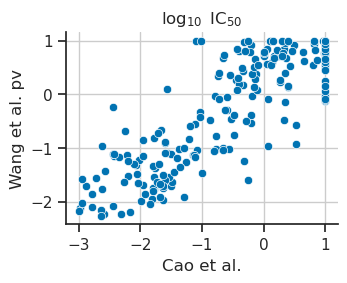

In [9]:
dfs = []
for strain in ['D614G', 'BA.1']:
    data = ic50s_df[
        ic50s_df['virus'] == strain
    ].pivot_table(
        index='antibody', columns='study', values='log_IC50'
    )
    dfs.append(data)
data = pd.concat(dfs)

plt.figure(figsize=[3.5,2.5])
sns.scatterplot(
    x='Cao et al.', y='Wang et al. pv', data=data
    #x='Wang et al. av', y='Wang et al. pv', data=data
)
#plt.axes(aspect='equal')
plt.title('$\log_{10}$ IC$_{50}$')
plt.grid()
sns.despine()
plt.show()

Compute a total escape score across all antibodies, weighted by the antibody's IC50 to the D614G strain, similar to the escape calculator.

Check Structure for clustered_window_data, use the one in your notebook use the csv maybe reformat structure to match this one 

['WT convalescents', 'WT vaccinees', 'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents']


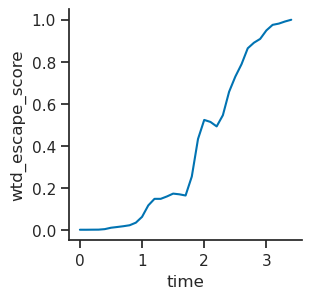

In [10]:
# Merge window escape data with data on IC50s
total_escape_window_data = clustered_window_data.merge(
    init_ic50s_df[['antibody', 'IC50', 'IC50_weight', 'source']],
    on='antibody'
)

# Compute weighted escape scores
total_escape_window_data['wtd_escape_score'] = \
    total_escape_window_data['mean_escape'] * \
        total_escape_window_data['IC50_weight']

# Plot total escape over time
sources = [
    'WT convalescents', 'WT vaccinees',
    'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents',
    #'SARS convalescents',
]
print(sources)
data = total_escape_window_data[
    total_escape_window_data['source'].isin(sources)
].copy()
data = data.groupby('time')[['wtd_escape_score']].sum().reset_index()
data['wtd_escape_score'] = data['wtd_escape_score'] / data['wtd_escape_score'].max()
plt.figure(figsize=[3,3])
sns.lineplot(x='time', y='wtd_escape_score', data=data)
sns.despine()
plt.show()

Plot escape over time

In [11]:
#getting rid of the noise clusters defined in CompleteClustering notebook
for index, row in clustered_window_data.iterrows():
    if row['cluster'] == -1.0 or row['cluster'] == 100.0:
        clustered_window_data.at[index, 'cluster'] = None
        clustered_window_data.at[index, 'sorted_cluster'] = None
clustered_window_data.head()

,Unnamed: 0.1,antibody,n_disallowed_aa_substitutions,mean_escape,time,ab_group,Unnamed: 0,UMAP Dimension 1,UMAP Dimension 2,cluster,sorted_cluster
0,0,B38,0.337963,0.000000,0.0,A,4,-2.580194,13.887926,3.0,3.0
1,1,B38,0.719101,0.000000,0.1,A,4,-2.580194,13.887926,3.0,3.0
2,2,B38,0.955326,0.000733,0.2,A,4,-2.580194,13.887926,3.0,3.0
3,3,B38,1.206478,0.002324,0.3,A,4,-2.580194,13.887926,3.0,3.0
4,4,B38,1.464286,0.005279,0.4,A,4,-2.580194,13.887926,3.0,3.0


['WT convalescents', 'WT vaccinees', 'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents']


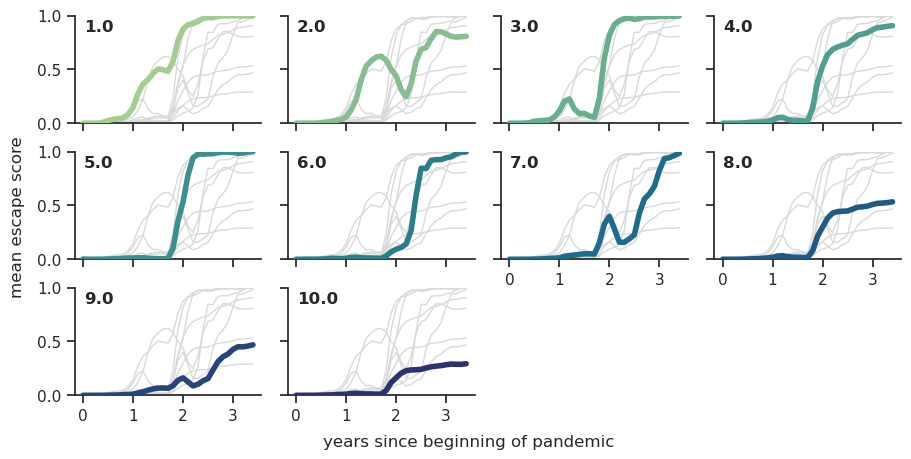

In [12]:
# Plot each antibody group's time series in its own facet

#clusters here were sorted in a way that was though tto be interesting, so just change sorted_cluster to the column 
#in yout dataframe that has cluster numbers??  or change the name in yout dataframe to sorted_cluster for simplicity
groupby_col = 'sorted_cluster' # 'ab_group' # 
data = clustered_window_data.groupby([groupby_col, 'time']).mean(numeric_only=True).reset_index()
g = sns.relplot(
    data=data,
    x="time", y="mean_escape", col=groupby_col, hue=groupby_col,
    kind="line", palette="crest", # 'husl', 
    linewidth=4, zorder=5,
    col_wrap=4, height=1.5, aspect=1.5,
    legend=False,
)

# Then plot other antibodies from group or other antibody
# groups in the background
groupby_cols = [
    #'antibody',
    groupby_col,
    'time'
]
plot_total_escape = False
for group, ax in g.axes_dict.items():

    if not plot_total_escape:
        
        # Plot every year's time series in the background
        if groupby_cols[0] == 'antibody':
            data = clustered_window_data[
                clustered_window_data[groupby_col] == group
            ].groupby(groupby_cols).mean(numeric_only=True).reset_index()
        else:
            data = clustered_window_data.groupby(groupby_cols).mean(numeric_only=True).reset_index()
        sns.lineplot(
            data=data, x="time", y="mean_escape", units=groupby_cols[0],
            estimator=None, color=".85", linewidth=1, ax=ax,
        )
    
    else:
        sources = [
            'WT convalescents', 'WT vaccinees',
            'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents',
            #'SARS convalescents',
        ]
        data = total_escape_window_data[
            total_escape_window_data['source'].isin(sources)
        ].copy()
        data = data.groupby('time')[['wtd_escape_score']].sum().reset_index()
        data['wtd_escape_score'] = data['wtd_escape_score'] / data['wtd_escape_score'].max()
        sns.lineplot(
            x='time', y='wtd_escape_score', data=data, ax=ax,
            color='0.25', #linewidth=4,
        )
    
    ax.set(yticks=[0,0.5,1], ylim=[0,1])
    ax.text(.05, .85, group, transform=ax.transAxes, fontweight="bold")

# Tweak the supporting aspects of the plot
print(sources)
g.set_titles("")
g.set_axis_labels("", "")
g.fig.text(0.5, -0.01, 'years since beginning of pandemic', ha='center')
g.fig.text(-0.01, 0.5, 'mean escape score', va='center', rotation='vertical')
g.tight_layout(h_pad=0.01)
plt.show()

Make a heatmap showing the number of antibodies from a given cluster from Cao et al. in a given cluster from K-means clustering.

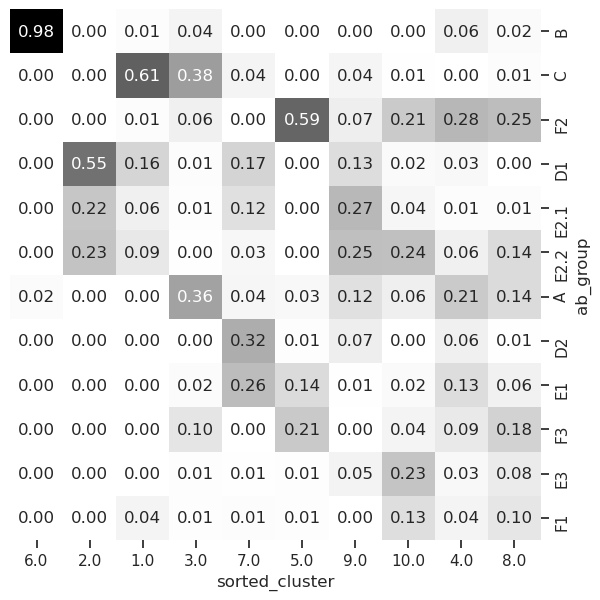

In [13]:
# Get a matrix with the number of antibodies in Cao clusters
# vs. K-means clusters
data = clustered_window_data[[
    'antibody', 'ab_group', 'sorted_cluster' 
]].drop_duplicates()
#data[['ab_group', 'sorted_cluster']].value_counts()
data = data.groupby(['ab_group', 'sorted_cluster']).count().reset_index()
data = data.pivot_table(
    index='ab_group', columns='sorted_cluster',
    values='antibody'
).fillna(0).apply(lambda col: col/col.sum())

# Plot the data
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", ["white", "black"])
cg = sns.clustermap(
    data, annot=True, fmt=".2f",
    row_cluster=True, col_cluster=True, cmap=cmap,
    figsize=(7.5,7.5)
)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)

For each cluster, plot the number of antibodies and distribution of IC50 values.

['WT convalescents', 'WT vaccinees', 'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents']


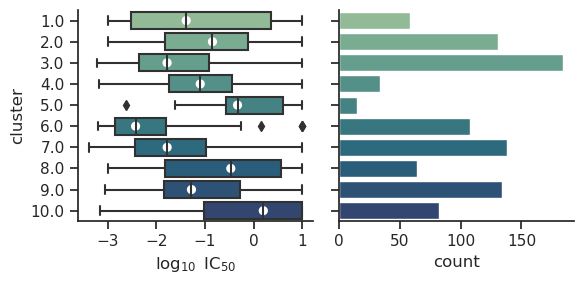

In [14]:
# Add a column to the IC50 df that gives the
# sorted cluster for each antibody
data = clustered_window_data[[
    'antibody', 'sorted_cluster', 'ab_group' 
]].copy().drop_duplicates()
data = init_ic50s_df.merge(data, on='antibody')

# Plot data
sources = [
    'WT convalescents', 'WT vaccinees',
    'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents',
    #'SARS convalescents',
]
print(sources)
data = data[data['source'].isin(sources)]

cluster_col = 'sorted_cluster' # 'ab_group'
data.sort_values(cluster_col, inplace=True)
(fig, axs) = plt.subplots(
    ncols=2, figsize=[6,3], sharey=True,
)
ic50_metric = 'log_IC50' # 'IC50_weight' # 
sns.boxplot(
    x=ic50_metric, y=cluster_col, data=data,
    orient='h', ax=axs[0], palette='crest'
)
sns.pointplot(
    x=ic50_metric, y=cluster_col, data=data,
    orient='h', ax=axs[0],
    join=False, estimator=np.median, errorbar=None,
    markers="o", scale=.75, color='w'
)
axs[0].set(ylabel='cluster', xlabel='$\log_{10}$ IC$_{50}$')
sns.countplot(
    y=cluster_col, data=data,
    ax=axs[1], palette='crest'
)
axs[1].set(ylabel='')
plt.tight_layout()
sns.despine()
plt.show()

**Observations**
* The order in which the antibodies were escaped does not really correlate with IC50 or number. This is the case even when subsetting to antibodies isolated from people infected/vaccinated with the "WT" strain

Make a list of mutations in each variant

First, intall required packages

In [15]:
!pip install Bio

Import required dependencies

In [16]:
from Bio import SeqIO
import sys
sys.path.append('data/')
import clusters
import scipy.stats

Helper function to get mutations

In [17]:
def get_mutations(refseq, seq):
    assert len(refseq) == len(seq)
    muts = [
        f'{ref_aa}{n}{aa}'
        for (n, (ref_aa, aa)) in enumerate(zip(refseq, seq), 1)
        if ref_aa != aa
    ]
    return muts

In [18]:
# Get list of sequences
seqs_dict = {}
for record in SeqIO.parse("data/ncov_escape_scores/aligned.gene.S.fasta", "fasta"):
    seqs_dict[record.id] = str(record.seq)
    
# For each sequence, make a list of mutations relative to the reference
ref_seq = seqs_dict['Wuhan-Hu-1/2019']
muts_dict = defaultdict(list)
for (seq_name, seq) in seqs_dict.items():
    muts_dict['virus'].append(seq_name)
    muts_dict['mutations'].append(
        set(get_mutations(ref_seq, seq)) # ' '.join(get_mutations(ref_seq, seq))
    )
    
muts_df = pd.DataFrame(muts_dict)

# Merge in clade info ##Use my escape Dataframe and Check for its structure 
clade_df = escape_df[['strain', 'Nextstrain_clade']].drop_duplicates().copy()
clade_df.rename(columns={'strain':'virus'}, inplace=True)
clade_df.head()
muts_df = muts_df.merge(clade_df, on='virus')
muts_df.head()

,virus,mutations,Nextstrain_clade
0,PRY/WOR12903A609_202103267_2-4710520/2020,{D614G},20D
1,CHN/20221209-7/2022,"{S477N, A27S, L452R, G142D, S371F, N440K, H69-...",22B (Omicron)
2,PER/00001AAFAT/2022,"{N370X, V320X, N331X, G142D, N360X, Y269X, G25...",22F (Omicron)
3,Argentina/UW21070556197/2021,"{D614G, Y248-, R246-, S247-, G252-, T859N, D25...",21G (Lambda)
4,CHN/NBCDC_20220315_HuYibo/2022,"{S477N, A27S, G142D, S371F, N440K, T376A, I122...",21L (Omicron)


In [19]:
# Get a dictionary giving the mutations in each clade
strain_muts_dict = clusters.clusters

# Map strains from IC50 experiments to clades from above dict
strain_and_clade_dict = {
    'Alpha' : 'Alpha',
    'Beta' : 'Beta',
    'Gamma' : 'Gamma',
    'Delta' : 'Delta',
    'Lambda' : '21GLambda',
    'BA.1' : '21K.Omicron',
    'BA.2' : '21L.Omicron',
    'BA.2.75' : '22D',
    'BA.5' : '22B',
    'BQ.1.1' : '22E',
    'XBB' : '22F'
}
strain_virus_dict = {
    'D614G' : ('Wuhan-Hu-1/2019', [])
}
muts_to_ignore = ['R493Q', 'Q493Q']
for (strain, clade) in strain_and_clade_dict.items():
    muts = [
        f"{entry['left']}{entry['pos']}{entry['right']}" for entry in
        strain_muts_dict[clade]['mutations']['nonsynonymous']
        if entry['gene'] == 'S'
    ]
    for mut in muts_to_ignore:
        if mut in muts:
            muts.remove(mut)
    if strain == 'BQ.1.1':
        muts.append('R346T')
    print(strain, muts)

    # Get the virus with the fewest differences
    muts_df['diffs'] = muts_df['mutations'].apply(
        lambda x: set.symmetric_difference(x, muts)
    )
    muts_df['ndiffs'] = muts_df['diffs'].apply(lambda x: len(x))
    muts_df.sort_values(['ndiffs', 'virus'], inplace=True)
    virus = muts_df['virus'].iloc[0]
    ndiffs = muts_df['ndiffs'].iloc[0]
    diffs = muts_df['diffs'].iloc[0]

    strain_virus_dict[strain] = (virus, muts)
    
    print(virus, ndiffs, diffs, '\n')

Alpha ['H69-', 'V70-', 'Y144-', 'N501Y', 'A570D', 'D614G', 'P681H', 'T716I', 'S982A', 'D1118H']
IRL/AIIDW008/2020 0 set() 

Beta ['D80A', 'D215G', 'L241-', 'L242-', 'A243-', 'K417N', 'E484K', 'N501Y', 'D614G', 'A701V']
TUN/TUN-202129459/2021 1 {'L18F'} 

Gamma ['L18F', 'T20N', 'P26S', 'D138Y', 'R190S', 'K417T', 'E484K', 'N501Y', 'D614G', 'H655Y', 'T1027I', 'V1176F']
VEN/Bol5332/2021 0 set() 

Delta ['T19R', 'G142D', 'E156-', 'F157-', 'R158G', 'L452R', 'T478K', 'D614G', 'P681R', 'D950N']
DJI/NAMRU3_C121/2021 0 set() 

Lambda ['G75V', 'T76I', 'R246-', 'S247-', 'Y248-', 'L249-', 'T250-', 'P251-', 'G252-', 'D253N', 'L452Q', 'F490S', 'D614G', 'T859N']
Argentina/UW21070556197/2021 0 set() 

BA.1 ['A67V', 'H69-', 'V70-', 'T95I', 'G142-', 'V143-', 'Y144-', 'Y145D', 'N211-', 'L212I', 'G339D', 'S371L', 'S373P', 'S375F', 'K417N', 'N440K', 'G446S', 'S477N', 'T478K', 'E484A', 'Q493R', 'G496S', 'Q498R', 'N501Y', 'Y505H', 'T547K', 'D614G', 'H655Y', 'N679K', 'P681H', 'N764K', 'D796Y', 'N856K', 'Q954H'

In [20]:
sorted([
    int(entry[1:-1]) for entry in
    set.symmetric_difference(
    set(strain_virus_dict['BA.2'][1]),
    set(strain_virus_dict['XBB'][1]))
])

[83, 144, 146, 183, 213, 213, 339, 339, 346, 368, 445, 446, 460, 486, 490, 493]

Merge predicted escape scores with measured IC50 values

In [21]:
# Get predicted escape scores for each strain
dfs = []
for (strain, strain_values) in strain_virus_dict.items():
    print(strain)
    data = escape_df[
        escape_df['strain'] == strain_values[0]
    ].copy()
    data['virus'] = strain
    dfs.append(data)
    
pred_ic50s = pd.concat(dfs)

D614G
Alpha
Beta
Gamma
Delta
Lambda
BA.1
BA.2
BA.2.75
BA.5
BQ.1.1
XBB


In [22]:
if 'escape_score' not in ic50s_df:
    ic50s_df = ic50s_df.merge(
        pred_ic50s[['virus', 'antibody', 'escape_score']],
        on=['antibody', 'virus'], how='left'
    )

Do experimentally IC50 values support the predicted escape scores? First, plot data for a single cluster.(change the cluster variable to get different results for different clusters 1.0-10.0)

236


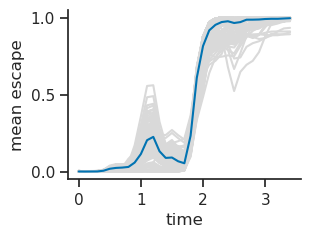

In [23]:
cluster = 3.0
data = clustered_window_data[
    clustered_window_data['sorted_cluster'] == cluster
].copy()
print(len(data['antibody'].unique()))
data = data.sample(frac=1, random_state=2)

antibodies = list(data[
    #(data['time'].between(2.2, 2.3)) &
    #(data['escape_score'] < 0.5) &
    (data['mean_escape'] > 0)
]['antibody'].unique())#[:5]
#antibodies = ['XGv-343', 'XGv-198', 'XGv-212', 'XGv-251']
#print(antibodies)

# Plot predictions
plt.figure(figsize=[3,2.2])
sns.lineplot(
    x='time', y='mean_escape',
    data=data[data['antibody'].isin(antibodies)],
    units='antibody', estimator=None, c='0.85',
    #hue='antibody', hue_order=antibodies
)
sns.lineplot(
    x='time', y='mean_escape',
    data=data[data['antibody'].isin(antibodies)],
    estimator='mean', errorbar=None
)
plt.yticks([0, 0.5, 1])
plt.ylabel('mean escape')
sns.despine()
plt.show()

Plot the distribution of IC50 values for a given set of antibodies from a given study.(change paramters based on rules for different clusters defined below this cell)

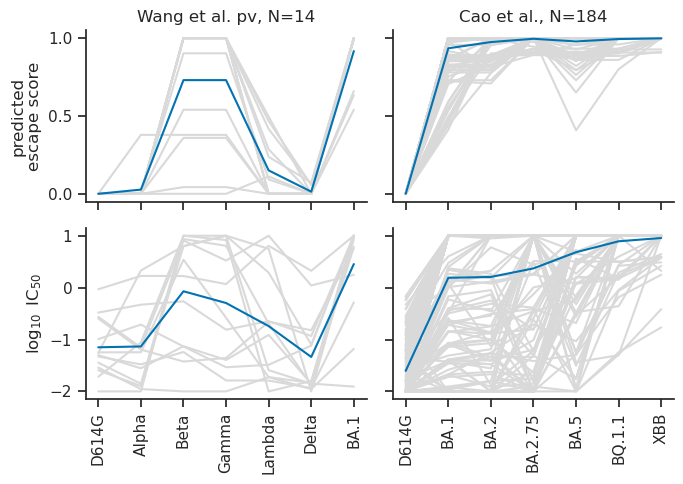

In [24]:
# Plotting params
virus_order = [
    'D614G',
    'Alpha', 'Beta', 'Gamma',
    'Lambda', 'Delta', 
    'Omicron',
    'BA.1', 'BA.2', 'BA.2.75',
    'BA.5', 'BQ.1.1',
    'XBB', 'XBB.1.5'
]
studies = [
    'Wang et al. pv',
    #'Wang et al. av',
    'Cao et al.',
]

(fig, axs) = plt.subplots(
    ncols=2, nrows=2, figsize=[7,5], sharex='col', sharey='row',
    gridspec_kw={'width_ratios': [1, 1]}
)
axs = axs.reshape(-1)

for (ax_i, study) in enumerate(studies):
    
    # Get IC50 data
    data = ic50s_df[
        (ic50s_df['antibody'].isin(antibodies)) &
        (ic50s_df['virus'].isin(virus_order)) &
        (ic50s_df['study'] == study)
    ].copy()
    data['log_IC50'].clip(lower=-2, inplace=True)

    # Sort the viruses for the x-axis
    virus_index_dict = {
        virus : i
        for (i, virus) in enumerate(virus_order)
    }
    data['order'] = data['virus'].apply(lambda x: virus_index_dict[x])
    data.sort_values('order', inplace=True)
    hue_order = sorted(data['antibody'].unique())
    
    # Select antibodies with a logIC50 below zero for D614G
    pivoted_data = data.pivot(
        index='antibody', columns='virus', values='log_IC50'
    )
    antibodies_to_plot = set(pivoted_data[
        (pivoted_data['D614G'] <= 0)
    ].index.values)
    
    # Select which antibodies to plot
    pivoted_data = data.pivot(
        index='antibody', columns='virus', values='escape_score' # 'log_IC50'
    )

    if 'Cao' in study:
        antibodies_to_plot = set.intersection(antibodies_to_plot, set(pivoted_data[
            (pivoted_data['BA.1'] > 0.4) & 
            #(pivoted_data['BA.5'] >0.1) & 
            #((pivoted_data['BA.1'] - pivoted_data['D614G']) > 0.5) &
            #((pivoted_data['BA.1'] - pivoted_data['BA.2']) > 0.5) &
            #((pivoted_data['BA.1'] - pivoted_data['BA.2']) < -0.5) &
            (pivoted_data['D614G'] <= 0)
        ].index.values))
    data = data[data['antibody'].isin(antibodies_to_plot)]

    # Plot data
    IC50_metric = 'log_IC50' #'escape_score' #  'IC50' # 
    for metric in ['escape_score', IC50_metric]:
        if metric == 'escape_score':
            n_abs = len(data['antibody'].unique())
            axs[ax_i].set(
                title=f'{study}, N={n_abs}',
                yticks=[0, 0.5, 1], ylabel='predicted\nescape score'
            )
            metric_ax_i = ax_i
        else:
            axs[ax_i+2].set(
                ylabel='$\log_{10}$ IC$_{50}$'
            )
            metric_ax_i = ax_i + 2
        sns.lineplot(
            x='virus', y=metric, data=data, ax=axs[metric_ax_i],
            units='antibody', estimator=None, c='0.85',
            #hue='antibody', hue_order=hue_order,
        )
        if True:
            sns.lineplot(
                x='virus', y=metric, data=data, ax=axs[metric_ax_i],
                estimator='mean', errorbar=None
            )

    for tick in axs[ax_i+2].get_xticklabels():
        tick.set_rotation(90)

axs[1].set(ylabel='')
axs[2].set(xlabel='')
axs[3].set(xlabel='', ylabel='')
plt.tight_layout()
sns.despine()
plt.show()

## Rules for clusters 
### cluster 2
* (pivoted_data['BA.1'] > 0.4)

### cluster 7
* (pivoted_data['BA.1'] > 0.4)

### cluster 9
* we played around with multiple paramaters, but none seemed to help the general shape in comparison to the log IC50


Show trajectories for subset of antibodies from indicated study

184


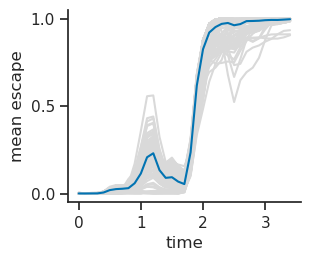

In [25]:
study = 'Cao et al.' # 'Wang et al. pv' # 
ic50_antibodies = ic50s_df[
    ic50s_df['study'] == study
]['antibody'].unique()
#antibodies_to_plot = list(set.intersection(set(antibodies), set(ic50_antibodies)))
data = clustered_window_data[
    #(clustered_window_data['sorted_cluster'] == cluster) &
    (clustered_window_data['antibody'].isin(antibodies_to_plot))
].copy()
print(len(data['antibody'].unique()))

# Plot predictions
plt.figure(figsize=[3,2.5])
sns.lineplot(
    x='time', y='mean_escape', data=data,
    units='antibody', estimator=None, c='0.85',
)
sns.lineplot(
    x='time', y='mean_escape', data=data,
    estimator='mean', errorbar=None
)
plt.yticks([0, 0.5, 1])
plt.ylabel('mean escape')
sns.despine()
plt.show()

Plot the correlation of escape score vs. IC50 values the subset of antibodies from each study

Wang et al. pv 0.58 0.0
Cao et al. 0.56 0.0


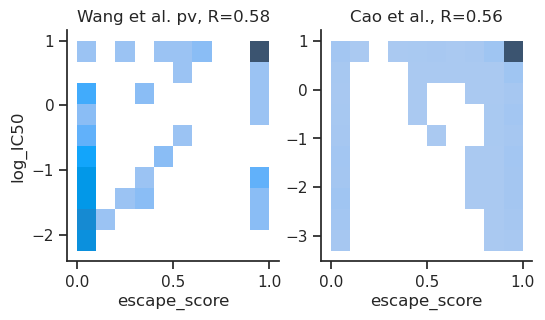

In [26]:
(fig, axs) = plt.subplots(
    ncols=2, figsize=[6,3],
    sharex=True, sharey=False
)
studies = ['Wang et al. pv', 'Cao et al.']
for (i, study) in enumerate(studies):
    data = ic50s_df[
        (ic50s_df['antibody'].isin(antibodies)) &
        #(ic50s_df['virus'].isin(['BA.2'])) &
        (ic50s_df['study'] == study)
    ].copy()
    (r, p) = scipy.stats.pearsonr(data['escape_score'], data['log_IC50'])
    print(study, round(r, 2), round(p, 2))

    sns.histplot(
        x='escape_score', y='log_IC50', data=data,
        bins=(10, 10), ax=axs[i]
    )
    axs[i].set(title=f'{study}, R={round(r, 2)}')

axs[1].set(ylabel='')
sns.despine()
plt.show()

Plot the distribution of R across antibodies from a given study

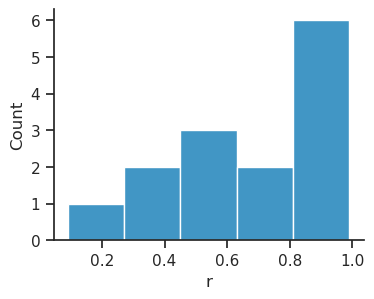

In [27]:
study = 'Wang et al. pv' # 'Cao et al.' # 
rs_dict = defaultdict(list)
for antibody in antibodies:
    data = ic50s_df[
        (ic50s_df['antibody'] == antibody) &
        (ic50s_df['study'] == study)
    ].copy()
    if len(data) < 1:
        continue
    (r, p) = scipy.stats.pearsonr(data['escape_score'], data['log_IC50'])
    rs_dict['antibody'].append(antibody)
    rs_dict['r'].append(r)

rs_df = pd.DataFrame(rs_dict)
plt.figure(figsize=[4,3])
sns.histplot(x='r', data=rs_df)
sns.despine()
plt.show()

In [28]:
rs_df.sort_values('r', ascending=False)

,antibody,r
2,XGv-152,0.990260
8,XGv-155,0.984927
1,LY-CoV016,0.977082
11,XGv-232,0.950820
10,XGv-416,0.926311
12,XGv-360,0.883688
3,XGv-055,0.795882
7,XGv-097,0.789397
13,XGv-094,0.616645
4,XGv-116,0.539647


In [29]:
ic50s_df[
    (ic50s_df['study'].isin(['Wang et al. pv'])) &
    (ic50s_df['antibody'] == 'XGv-155')
]

,antibody,virus,IC50,study,log_IC50,source,escape_score
19337,XGv-155,D614G,0.025513,Wang et al. pv,-1.593240,WT vaccinees,0.0000
19338,XGv-155,Alpha,0.012695,Wang et al. pv,-1.896352,WT vaccinees,0.0000
19339,XGv-155,Beta,6.256780,Wang et al. pv,0.796351,WT vaccinees,1.0000
19340,XGv-155,Gamma,10.000000,Wang et al. pv,1.000000,WT vaccinees,1.0000
19341,XGv-155,Delta,0.014066,Wang et al. pv,-1.851839,WT vaccinees,0.0000
19342,XGv-155,Lambda,0.025609,Wang et al. pv,-1.591605,WT vaccinees,0.2855
19343,XGv-155,BA.1,10.000000,Wang et al. pv,1.000000,WT vaccinees,1.0000


## Getting and understanding relavent mut-sites for each cluster

Analyze trends for individual antibodies in a given cluster

In [30]:
#tells you antibodies in that cluster. 
cluster = 2
data = clustered_window_data[
    clustered_window_data['cluster'] == cluster
].copy()
print(len(data['antibody'].unique()))
#randomizes the order of the antibodies in the list 
#data = data.sample(frac=1, random_state=2)

antibodies = list(data['antibody'].unique())#[:5]
antibodies[:4]

137


['BD-864', 'BD55-1962', 'BD55-5836', 'BD55-5904']

BD55-1035


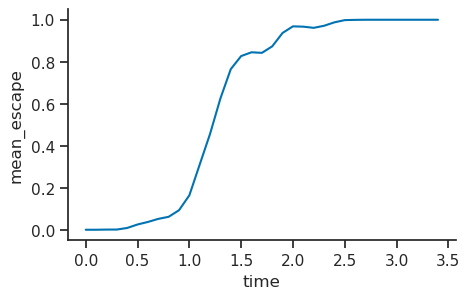

In [31]:
antibody = 'BD55-1035' #'LY-CoV016' # 'XGv-198' # 'XGv-152' # 'XGv-097' # 'XGv-010' # , 'XGv-172', 'XGv-271' # 'BD-824' # 'B38' # '2-15' # 'BD55-939'# 'BD56-1892' # '1-57' # 'BD55-1962' # 'BD55-1035' # 'BD55-1066' # antibodies[3] # 'BD-623' # '1-57' #
print(antibody)
ab_window_data = clustered_window_data[clustered_window_data['antibody'] == antibody].copy()
plt.figure(figsize=[5,3])
sns.lineplot(x='time', y='mean_escape', data=ab_window_data)
sns.despine()
plt.show()

In [32]:
escape_df[
    (escape_df['time'].between(2, 2.9)) &
    #(escape_df['Nextstrain_clade'].str.contains('Delta')) &
    (escape_df['escape_score'] > 0.2) &
    (escape_df['antibody'] == antibody)
].sort_values('escape_score', ascending=False).head()

,strain,all_aa_substitutions,measured_aa_substitutions,unmeasured_aa_substitutions,disallowed_aa_substitutions,n_disallowed_aa_substitutions,escape_score,antibody,ab_group,date,Nextstrain_clade,time
7516587,JPN/HiroC450/2022,T19I L24- P25- P26- A27S H69- V70- G142D V213G...,L452R E484A F486V,T19I L24- P25- P26- A27S H69- V70- G142D V213G...,T19I L24- P25- P26- A27S H69- V70- G142D V213G...,31,1.0,BD55-1035,C,2022-09-06,22B (Omicron),2.706849
7386021,CHN/GD-5/2022,T19I L24- P25- P26- A27S H69- V70- G142D V213G...,L452R E484A F486V,T19I L24- P25- P26- A27S H69- V70- G142D V213G...,T19I L24- P25- P26- A27S H69- V70- G142D V213G...,32,1.0,BD55-1035,C,2022-07-01,22B (Omicron),2.523288
7422135,IND/NGS-693/2022,T19I L24- P25- P26- A27S H69- V70- G142D V213G...,L452R E484A F486V,T19I L24- P25- P26- A27S H69- V70- G142D V213G...,T19I L24- P25- P26- A27S H69- V70- G142D V213G...,33,1.0,BD55-1035,C,2022-05-20,22B (Omicron),2.408219
7419357,IND/NGS-966/2022,T19I L24- P25- P26- A27S H69- V70- G142D V213G...,L452R E484A F486V,T19I L24- P25- P26- A27S H69- V70- G142D V213G...,T19I L24- P25- P26- A27S H69- V70- G142D V213G...,34,1.0,BD55-1035,C,2022-08-10,22B (Omicron),2.632877
7416579,IND/NGS-1176/2022,T19I L24- P25- P26- A27S H69- V70- G142D V213G...,L452R E484A F486V,T19I L24- P25- P26- A27S H69- V70- G142D V213G...,T19I L24- P25- P26- A27S H69- V70- G142D V213G...,34,1.0,BD55-1035,C,2022-09-27,22B (Omicron),2.764384


In [33]:
leftSides = pd.read_csv("./Results/FinalResults/list_of_left_sides_of_windows.csv")
list_of_left_sides_of_windows = leftSides['0'].tolist()

For all sites with DMS data that escape the antibody, compute the correlation between the mutation's trajectory and the escape trajectory.

In [34]:
# Get a list of mutations to analyze
window_width = 0.2
mut_sites = list(site_escape_df[
    #(site_escape_df['escape'] > 0.9) &
    #(site_escape_df['antibody'] == antibody)
    (site_escape_df['antibody'].isin(antibodies))
]['site'])

# Compute the frequency of each mutation over time
mut_freq_dict = defaultdict(list)
dfs = []
for left_side_of_window in list_of_left_sides_of_windows:
    right_side_of_window = left_side_of_window + window_width
    center_of_window = (left_side_of_window + right_side_of_window) / 2
    
    # Get data for viruses within a given window
    data = escape_df[
        (escape_df['antibody'] == antibody) &
        (escape_df['time'].between(left_side_of_window, right_side_of_window))
    ].copy()
    #all_aa_substitutions used to be aa_substitutions
    data['all_aa_substitutions'].fillna('', inplace=True)
    
    # Record the frequency of each mutation
    for mut_site in mut_sites:
        mut_freq_dict['time'].append(center_of_window)
        mut_freq_dict['mut_site'].append(mut_site)
        mut_freq_dict['mut_freq'].append(
            #all_aa_substitutions used to be aa_substitutions
            sum(data['all_aa_substitutions'].str.contains(f'\w{mut_site}\w')) / len(data)
        )

mut_freq_df = pd.DataFrame(mut_freq_dict)
mut_freq_df['mut_freq'].fillna(0, inplace=True)

In [35]:
# # Compute the frequency of each mutation in each clade
# clade_mut_freq_dict = defaultdict(list)
# dfs = []
# for clade in sorted(list(escape_df['Nextstrain_clade'].unique())):
    
#     # Get data for viruses within a given clade
#     data = escape_df[
#         (escape_df['antibody'].isin(antibodies)) &
#         #(escape_df['antibody'] == antibody) &
#         (escape_df['Nextstrain_clade'] == clade)
#     ].copy()
#     #all_aa_substitutions used to be aa_substitutions
#     data['all_aa_substitutions'].fillna('', inplace=True)
    
#     # Record the frequency of each mutation
#     for mut_site in mut_sites:
#         clade_mut_freq_dict['clade'].append(clade)
#         clade_mut_freq_dict['mut_site'].append(mut_site)
#         clade_mut_freq_dict['mut_freq'].append(
#             #all_aa_substitutions used to be aa_substitutions
#             sum(data['all_aa_substitutions'].str.contains(f'\w{mut_site}\w')) / len(data)
#         )

# clade_mut_freq_df = pd.DataFrame(clade_mut_freq_dict)
# clade_mut_freq_df['mut_freq'].fillna(0, inplace=True)

In [36]:
data = ab_window_data.merge(mut_freq_df, on='time')
data['abs_error'] = abs(data['mean_escape'] - data['mut_freq'])
corr_dict = defaultdict(list)
for mut_site in mut_sites:
    data_i = data[data['mut_site'] == mut_site]
    mae = round(data_i['abs_error'].mean(), 2)
    r = round(data_i['mean_escape'].corr(data_i['mut_freq']), 2)
    corr_dict['site'].append(mut_site)
    corr_dict['max_freq'].append(round(data_i['mut_freq'].max(), 2))
    corr_dict['mae'].append(mae)
    corr_dict['r'].append(r)
    
corr_df = pd.DataFrame(corr_dict)

# ab_site_escape_df = site_escape_df[
#     (site_escape_df['antibody'] == antibody)
# ].copy()



ab_site_escape_df = site_escape_df[
    site_escape_df['antibody'].isin(antibodies)
].copy()

# Sort the DataFrame by the 'escape' column in descending order
ab_site_escape_df = ab_site_escape_df.sort_values(by='escape', ascending=False)



corr_df = corr_df.merge(ab_site_escape_df, on='site', how='left')
corr_df['r'].fillna(0, inplace=True)
#corr_df.sort_values('r', ascending=False, inplace=True)
corr_df.sort_values('escape', ascending=False, inplace=True)
corr_df.head(n=12)

,site,max_freq,mae,r,antibody,escape
0,444,0.22,0.53,0.48,C110,1.0
139080,444,0.22,0.53,0.48,BD55-5962,1.0
139216,447,0.00,0.56,0.00,BD57-085,1.0
139217,447,0.00,0.56,0.00,BD55-958,1.0
139218,447,0.00,0.56,0.00,BD55-606,1.0
139219,447,0.00,0.56,0.00,XGv-263,1.0
139220,447,0.00,0.56,0.00,COVOX-75,1.0
139307,448,0.00,0.56,0.00,BD56-443,1.0
32226,447,0.00,0.56,0.00,COVOX-75,1.0
32225,447,0.00,0.56,0.00,XGv-263,1.0


In [37]:
#this shows count for sites, filter r value to get the sites you want.
#IMPORTANT: 
data = corr_df[(corr_df['r'] > 0.2)& (corr_df['escape']>0.5) ]
data['site'].value_counts()

452    11782
450     6328
490     5130
346     4508
444     1792
356     1782
446     1600
348      770
494      744
484      267
496      150
Name: site, dtype: int64

Making the clade frequency dataframe

In [38]:
# Initiate a series with zero counts for each clade
zeros_dict = {
    clade : 0
    for clade in escape_df['Nextstrain_clade'].unique()
}
zeros_series = pd.Series(zeros_dict)

# Iterate over each window and record data
list_of_series = []
for left_side_of_window in list_of_left_sides_of_windows:
    right_side_of_window = left_side_of_window + window_width
    
    # Get data for viruses within a given window
    data = escape_df[
        (escape_df['time'].between(left_side_of_window, right_side_of_window))
    ].copy()
    data.drop_duplicates(subset='strain', inplace=True)
    clade_counts = (data['Nextstrain_clade'].value_counts() + zeros_series).fillna(0)
    clade_freqs = clade_counts / clade_counts.sum()
    list_of_series.append(clade_freqs)

clade_freqs_df = pd.DataFrame(list_of_series)
clade_freqs_df['time'] = list_of_left_sides_of_windows
clade_freqs_df['time'] += window_width/2
value_vars = [col for col in clade_freqs_df if col != 'time']
clade_freqs_df = clade_freqs_df.melt(
    id_vars='time', value_vars=value_vars,
    var_name='clade', value_name='freq'
)
clade_freqs_df.head()

,time,clade,freq
0,0.1,19A,0.652778
1,0.2,19A,0.397004
2,0.3,19A,0.189003
3,0.4,19A,0.129555
4,0.5,19A,0.015306


Plot data

BD55-1035


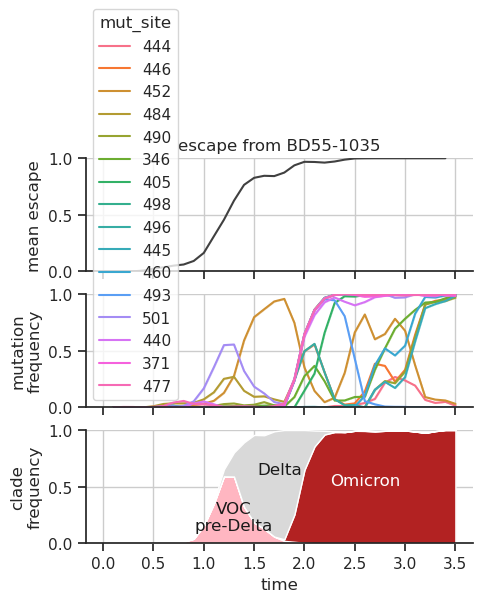

In [39]:
# Plot data
print(antibody)
(fig, axs) = plt.subplots(
    nrows=3, sharex=True, sharey=True,
    figsize=[5,5]
)

# Plot changes in escape score over time
data = ab_window_data[ab_window_data['antibody'] == antibody].copy()
sns.lineplot(
    x='time', y='mean_escape', data=data, ax=axs[0], c='0.25'
)
axs[0].set(
    ylabel=f'mean escape', ylim=[0,1],
    title=f'escape from {antibody}'
)

# Plot changes in mutation frequency
sites_to_plot = corr_df[
    #(corr_df['mae'] < 0.4) &
    (corr_df['r'] > 0.2) &
    (corr_df['max_freq'] > 0.1) &
    (corr_df['escape'] > 0.1) # 0.1
]['site']
sites_to_plot = list(map(str, sites_to_plot))
data = mut_freq_df.copy()
data['mut_site'] = data['mut_site'].astype(str)
data = data[data['mut_site'].isin(sites_to_plot)]
sns.lineplot(
    x='time', y='mut_freq', data=data, hue='mut_site', ax=axs[1],
    #hue_order=['484', '490', '452']
)
axs[1].set(ylabel='mutation\nfrequency')

# Plot clade frequency
clade_plotting_params = {
    'B38' : [
        ('VOC\npre-Delta', ['Alpha', 'Beta', 'Gamma', 'Kappa', 'Eta', 'Theta', 'Mu'], 1.30, 0.23, 'k'),
        ('Omicron', ['Omicron'], 2.6, 0.55, 'w'),
        ('Delta', ['Delta'], 1.75, 0.65, 'k'),
    ],
    'LY-CoV016' : [
        ('VOC\npre-Delta', ['Alpha', 'Beta', 'Gamma', 'Kappa', 'Eta', 'Theta', 'Mu'], 1.30, 0.23, 'k'),
        ('Omicron', ['Omicron'], 2.6, 0.55, 'w'),
        ('Delta', ['Delta'], 1.75, 0.65, 'k'),
    ],
    '2-15' : [
        ('VOC\npre-Delta', ['Alpha', 'Beta', 'Gamma', 'Kappa', 'Eta', 'Theta', 'Mu'], 1.30, 0.23, 'k'),
        ('Omicron', ['Omicron'], 2.6, 0.55, 'w'),
        ('Delta', ['Delta'], 1.75, 0.65, 'k'),
    ],
    
    'BD55-1962' : [
        ('Delta', ['Delta'], 1.75, 0.35, 'k'),
        ('Omicron\npost-21L', ['22A', '22B', '22C', '22D', '22E', '22F', '23A', '23B'], 2.75, 0.375, 'w'),
        ('Omicron\n21K/L', ['21K', '21L'], 2.2, 0.65, 'k'),
    ],
    '1-57' : [
        ('21K', ['21K'], 2.1, 0.25, 'k'),
        ('22D/F\n23A/B', ['22D', '22F', '23A', '23B'], 3.0, 0.15, 'w'),
        ('21L-\n22C/E', ['21L', '22A', '22B', '22C', '22E'], 2.6, 0.65, 'k'),
    ],
    'BD-824' : [
        ('21K', ['21K'], 2.1, 0.25, 'k'),
        ('22F\n23A/B', ['22F', '23A', '23B'], 3.0, 0.15, 'w'),
        ('21L-\n22E', ['21L', '22A', '22B', '22C', '22D', '22E'], 2.6, 0.65, 'k'),
    ],
    
    'BD-623' : [
        ('', [''], 2.1, 0.25, 'k'),
        ('22A/B/E/F,\n23A/B', ['22A', '22B', '22E', '22F', '23A', '23B'], 2.85, 0.5, 'w'),
        ('', [''], 2.6, 0.65, 'k'),
    ],
    'BD55-1035' : [
        ('VOC\npre-Delta', ['Alpha', 'Beta', 'Gamma', 'Kappa', 'Eta', 'Theta', 'Mu'], 1.30, 0.23, 'k'),
        ('Omicron', ['Omicron'], 2.6, 0.55, 'w'),
        ('Delta', ['Delta'], 1.75, 0.65, 'k'),
    ],
    'BD-449' : [
        ('', [''], 2.1, 0.25, 'k'),
        ('Omicron', ['Omicron'], 2.6, 0.5, 'w'),
        ('', [''], 2.6, 0.65, 'k'),
    ],
    'BD-498' : [
        ('21K', ['21K'], 2.1, 0.25, 'k'),
        ('22D/F,\n23A/B', ['22D', '22F', '23A', '23B'], 3.1, 0.15, 'k'),
        ('21L,\n22A/B/C/E', ['21L', '22A', '22B', '22C', '22E'], 2.6, 0.65, 'k'),
    ],
    'BD55-1066' : [
        ('VOC\npre-Delta', ['Alpha', 'Beta', 'Gamma', 'Kappa', 'Eta', 'Theta', 'Mu'], 1.30, 0.23, 'k'),
        ('Omicron', ['Omicron'], 2.6, 0.55, 'w'),
        ('Delta', ['Delta'], 1.75, 0.65, 'k'),
    ],
}

clade_freqs_df.sort_values('time', inplace=True)
dfs = []
for params in clade_plotting_params[antibody]:
    (group_name, clade_strs, text_x, text_y, text_c) = params
    data = clade_freqs_df[
        clade_freqs_df['clade'].str.contains('|'.join(clade_strs))
    ].copy()
    data = data.groupby('time').sum(numeric_only=True)
    data['clade'] = group_name
    if group_name == '':
        data['freq'] = 0
    dfs.append(data)
    axs[2].text(
        text_x, text_y, group_name, c=text_c,
        ha='center', va='center'
    )

axs[2].stackplot(
    dfs[0].index, dfs[0]['freq'], dfs[1]['freq'], dfs[2]['freq'],
    #labels=['VOCs pre-Delta', 'Omicron', 'Delta'],
    colors=['lightpink', 'firebrick', '0.85'],
    baseline='zero', #zorder=0
)
axs[2].set(xlabel='time', ylabel='clade\nfrequency')
#axs[1].get_legend(bbox_to_anchor=(1,1))
for i in range(3):
    axs[i].grid()

sns.despine()
plt.show()


plotting just the mut-sites. manually put in mut_sites wanted for trajectory

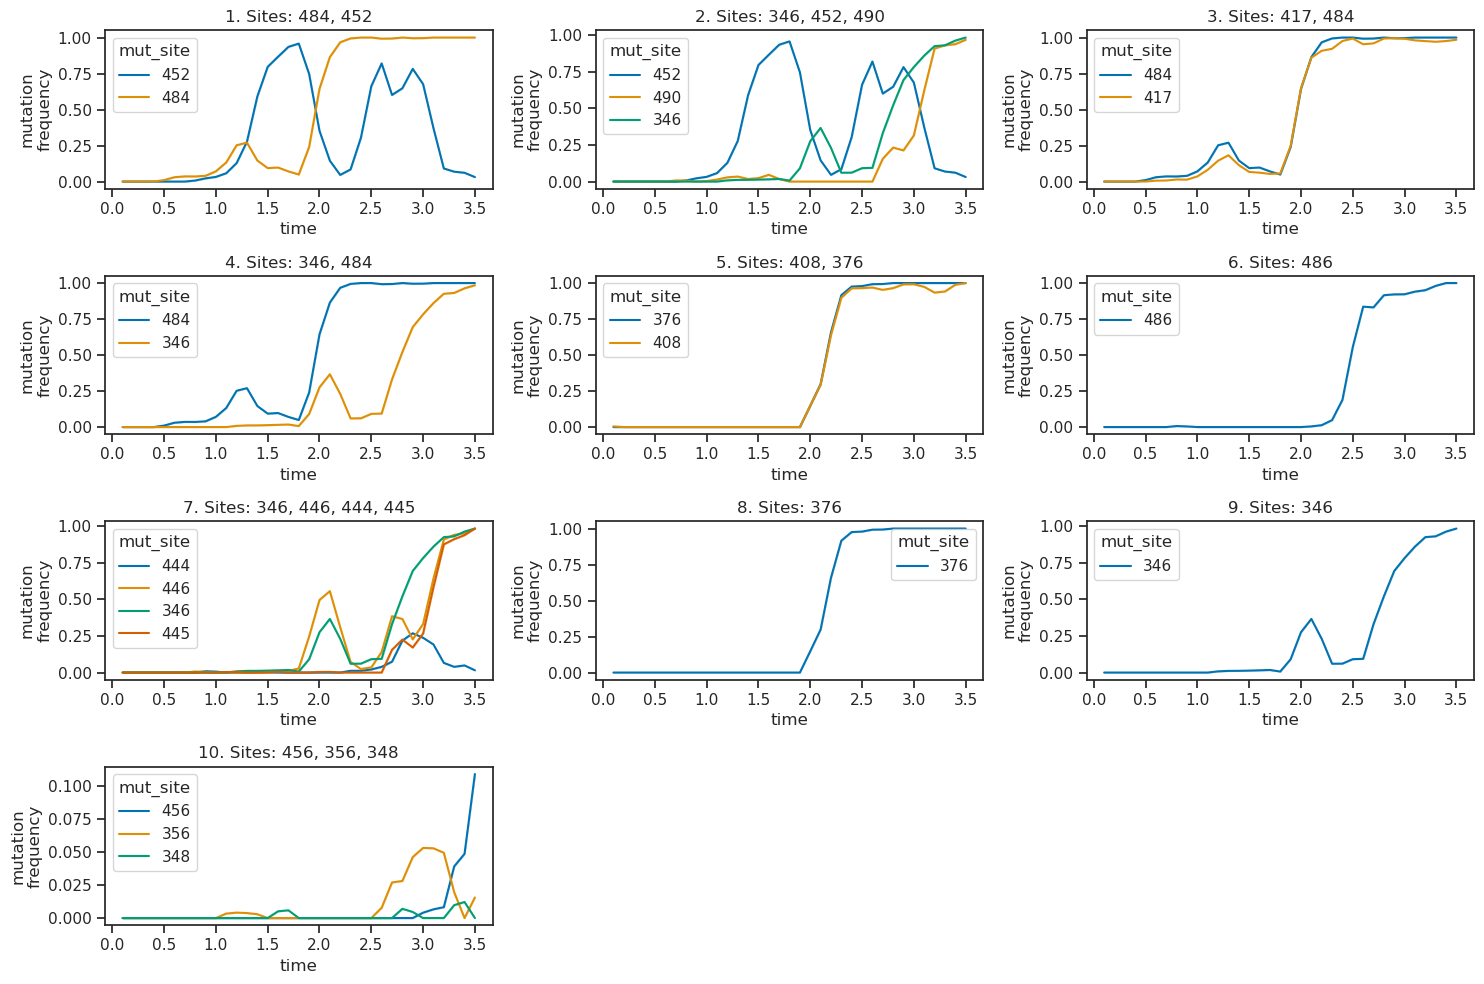

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Array of arrays of sites
site_groups = [['484', '452'], ['346', '452','490'], ['417', '484'], ['346', '484'], ['408', '376'], 
               ['486'], ['346', '446', '444', '445'], ['376'], ['346'], ['456', '356', '348']]

# Create subplots
num_plots = len(site_groups)
cols = 3
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

for idx, sites in enumerate(site_groups):
    # Copy and filter the data
    data = mut_freq_df.copy()
    data['mut_site'] = data['mut_site'].astype(str)
    data = data[data['mut_site'].isin(sites)]
    
    # Plot the data
    sns.lineplot(
        x='time', y='mut_freq', data=data, hue='mut_site', ax=axes[idx]
    )
    axes[idx].set_ylabel('mutation\nfrequency')
    axes[idx].set_title(f'{idx + 1}. Sites: {", ".join(sites)}')

# Remove any unused subplots
for i in range(len(site_groups), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

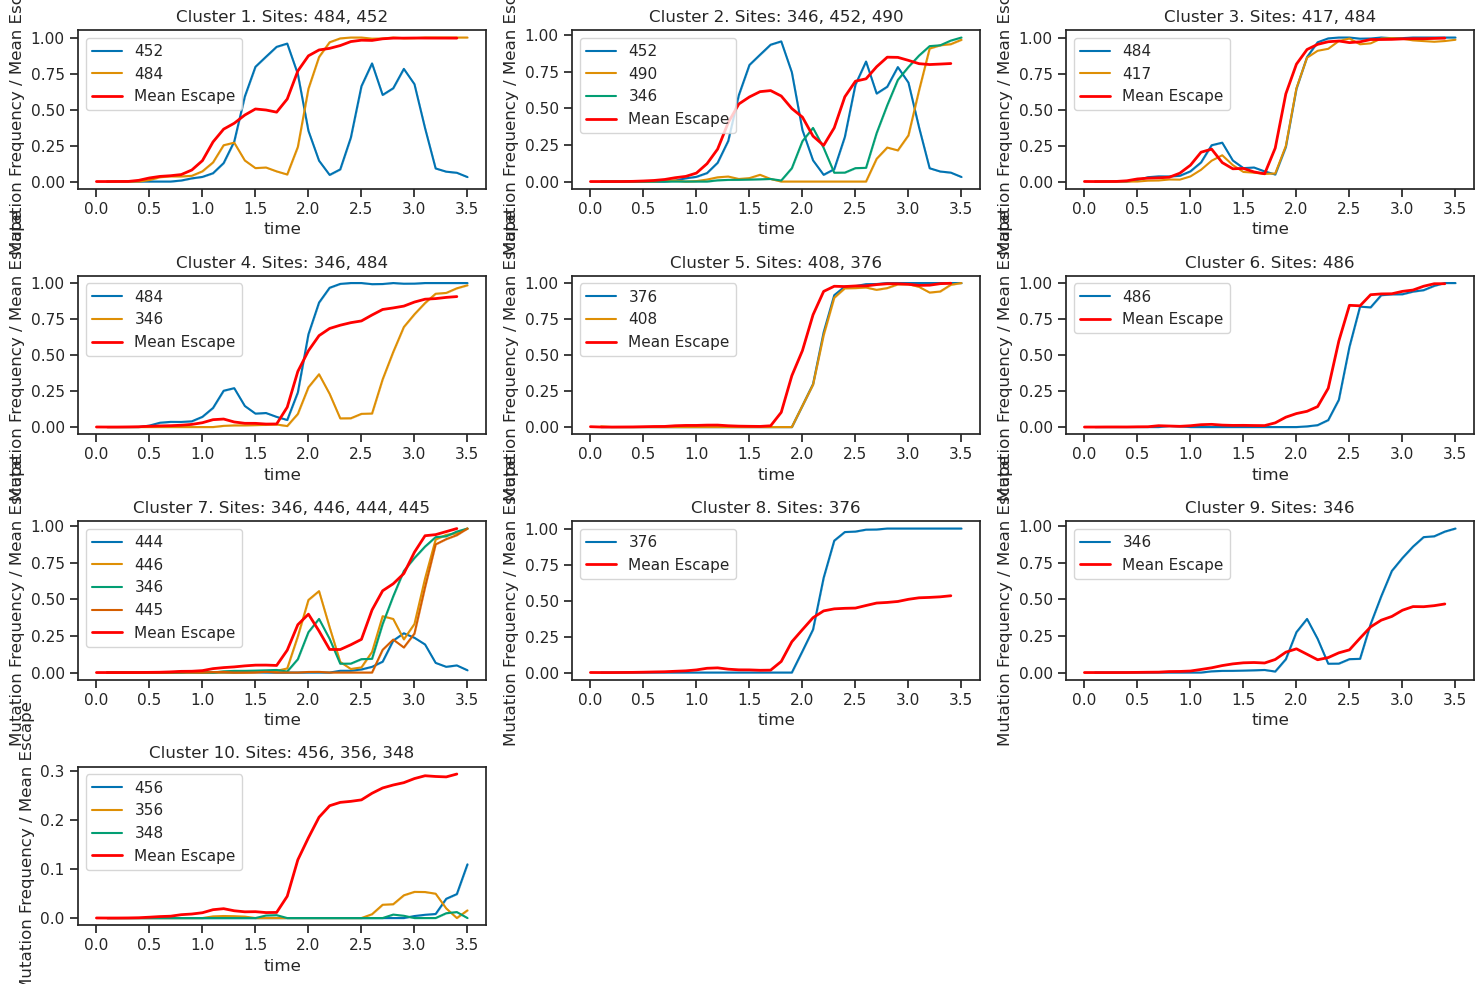

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Array of arrays of sites
site_groups = [['484', '452'], ['346', '452','490'], ['417', '484'], ['346', '484'], ['408', '376'], 
               ['486'], ['346', '446', '444', '445'], ['376'], ['346'], ['456', '356', '348']]

# Create subplots
num_plots = len(site_groups)
cols = 3
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

groupby_col = 'sorted_cluster' 

for idx, (sites, ax) in enumerate(zip(site_groups, axes)):
    # Filter the mutation frequency data
    mut_data = mut_freq_df.copy()
    mut_data['mut_site'] = mut_data['mut_site'].astype(str)
    mut_data = mut_data[mut_data['mut_site'].isin(sites)]
    
    # Plot the mutation frequency data
    sns.lineplot(
        x='time', y='mut_freq', data=mut_data, hue='mut_site', ax=ax
    )
    
    # Filter the clustered window data
    cluster_data = clustered_window_data[
        clustered_window_data[groupby_col] == idx + 1  # Adjusted indexing
    ].groupby(['time']).mean(numeric_only=True).reset_index()
    
    # Plot the mean escape data
    sns.lineplot(
        x='time', y='mean_escape', data=cluster_data, ax=ax,
        color='red', linewidth=2, label='Mean Escape'
    )
    
    ax.set_ylabel('Mutation Frequency / Mean Escape')
    ax.set_title(f'Cluster {idx + 1}. Sites: {", ".join(sites)}')
    ax.legend()

# Remove any unused subplots
for I in range(len(site_groups), len(axes)):
    fig.delaxes(axes[I])

plt.tight_layout()
plt.show()

In [ ]:
escape_df[escape_df['antibody'] == 'BD55-1962']

Plot the frequency of a mutation among clades

In [ ]:
data = clade_mut_freq_df[
    clade_mut_freq_df['mut_site'] == 346
]
plt.figure(figsize=[5,7])
sns.barplot(x='mut_freq', y='clade', data=data)
plt.show()

In [ ]:
escape_df[
    (escape_df['Nextstrain_clade'].str.contains('Omicron')) &
    (escape_df['antibody'] == antibody) &
    (escape_df['time'] < 0.5)
]

Observations
* B38 from group A
    * alpha has the N501Y escape mutation (escape score of 0.27)
    * beta and gamma have the K417N, E484K, and N501Y escape mutations
    * delta lacks  these mutations
    * omicron has the K417N, E484A, N501Y escape mutations
    * the above mutations spike and dip at the same time as the average-escape plot
* 2-15 from group C
    * same as above, but for the 484 mutation?

* BD-623 from group B
    * escape at 486

* 1-57 from group D1
    * escape patterns track with mutations at 446 (G446S?)
    * BA.1 has this mutation, BA.2 does not, but then it occurs later on in omicron evolution    
* BD55-1962 from group D1
    * escape at 452
    
* BD55-1036 from group D2
    * escape at 445
* BD55-1104 from group D2
    * escape at 444, 445, 446
    
* BD55-1245 from group E1
    * escape at 371, 373
    
* BD-713 from group E2.1
    * escape at 346, 452, 484
    * accumulation of multiple partial-escape mutations
* BD-744 from group E2.1
    * escape at 346, 452
    * interesting tradeoff between mutations
* BD55-1312 from group E2.1
    * escape at 484, 490
    * accumulation of multiple partial-escape mutations
* BD-901 from group E2.1
    * escape at 346, 376, 490
    * accumulation of multiple partial-escape mutations
    
* ADG-2 from group F3
    * escape at 408 with partial escape at 484, 505
* BD55-5259 from group F3
    * partial escape at 375, 505
* BD55-5448 from group F3
    * partial escape at many sites: 405, 408, 484, 496, 501, 505

## Validate predictions

In [ ]:
# Make a list of input files, with one file per antibody
ab_escape_files = glob.glob('data/ncov_escape_scores/*escape_prediction.csv')

# Read in data from each file and store data in a dataframe
antibodies = []
for (i, f) in enumerate(ab_escape_files):
    df = pd.read_csv(f)
    ab = os.path.basename(f).replace('_polclonal_escape_prediction.csv', '').replace('_escape_score_variant_escape_prediction.csv', '')
    if 'additive' in df.columns.values:
        escape_score_col = f'{ab}_escape_score'
        df.rename(columns={'additive' : escape_score_col}, inplace=True)
    else:
        escape_score_col = f'{ab}_IC90_log_fold_change'

    if i == 0:
        escape_df = df[['strain', 'aa_substitutions', escape_score_col]]
    else:
        escape_df = escape_df.merge(
            df[['strain', escape_score_col]],
            on='strain'
        )
    antibodies.append(escape_score_col)

# Add a column giving the date of each strain
metadata_df = pd.read_csv(
    'data/ncov_escape_scores/metadata_with_index.tsv',
    sep='\t', on_bad_lines='skip'
    )

escape_df = escape_df.merge(
    metadata_df[['strain', 'date', 'Nextstrain_clade']], on='strain'
)
escape_df['date'] = pd.to_datetime(escape_df['date'])
escape_df['time'] = (escape_df['date'] - escape_df['date'].min()).dt.days / 365
escape_df.head()

In [ ]:
ly_cov1404_ic50s = [
    ('BA.2', 0.9),
    ('XBB', 10000),
    ('BA.2.75', 2.2),
    ('BA.5', 0.8),
    ('BQ.1.1', 1905),
]
ly_cov1404_dict = defaultdict(list)
for (strain, ic50) in ly_cov1404_ic50s:
    ly_cov1404_dict['strain'].append(strain)
    ly_cov1404_dict['virus'].append(strain_virus_dict[strain][0])
    ly_cov1404_dict['log_ic50'].append(np.log10(ic50))

ly_cov1404_ic50s_df = pd.DataFrame(ly_cov1404_dict)

In [ ]:
ly_cov1404_escape = escape_df[['strain', 'LY-CoV1404-BA1_escape_score']].copy()
ly_cov1404_escape.rename(columns={
    'strain' : 'virus',
    'LY-CoV1404-BA1_escape_score' : 'escape_score'
}, inplace=True)
ly_cov1404_escape = ly_cov1404_escape.merge(ly_cov1404_ic50s_df, on='virus')

In [ ]:
plt.figure(figsize=(3,3))
sns.scatterplot(x='escape_score', y='log_ic50', data=ly_cov1404_escape)
sns.despine()
plt.show()

In [ ]:
plt.figure(figsize=(3,3))
sns.relplot(x='escape_score', y='log_ic50', data=ly_cov1404_escape)
sns.despine()
plt.show()

In [ ]:
strain_virus_dict['BA.2']

In [ ]:
ic50s_df[
    ic50s_df['antibody'].str.contains('LY')
]#['antibody'].unique()